In [1]:
import numpy as np
import pymc as pm

from pyei.data import Datasets
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf

/Users/mahir/416/c1/ei_test/ei_venv/lib/python3.12/site-packages/numba/core/decorators.py:248: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [ ]:
# get columns of interest

import pandas as pd

raw_df = pd.read_csv("2020_eavs_data/eavs_2020_latest.csv", dtype=str, keep_default_na=False, na_values=[], low_memory=False)
raw_df = raw_df.query("State_Abbr == 'FL'")

raw_df.to_csv("florida_rejection_rates_raw.csv", index=False)

rename_map = {
    # metadata columns that anchor the data before totals
    "State_Abbr": "State_Abbr",
    "Jurisdiction_Name": "Jurisdiction_Name",
    "FIPSCode": "FIPSCode",

    # counted ballot totals
    "B14a": "uocava_counted_total",
    "B15a": "post_mail_counted_total",
    "B16a": "email_counted_total",
    "B17a": "other_counted_total",
    "C3a": "by_mail_counted_total",
    "B24a": "total_fwab_counted",
    "E1b": "provisional_counted_full_ballot",

    # rejected ballot totals
    "B3a": "rejected_fpca_total",
    "B18a": "uocava_rejected_total",
    "B19a": "deadline_rejected_total",
    "B20a": "signature_rejected_total",
    "B21a": "postmark_rejected_total",
    "B22a": "other_rejected_total",
    "C4a": "by_mail_rejected_total",
}

df = raw_df[list(rename_map.keys())].rename(columns=rename_map)

print(df.head())
df.to_csv("florida_rejection_rates.csv", index=False)


    State_Abbr Jurisdiction_Name    FIPSCode uocava_counted_total  \
454         FL    ALACHUA COUNTY  1200100000                 1578   
455         FL      BAKER COUNTY  1200300000                   55   
456         FL        BAY COUNTY  1200500000                 2483   
457         FL   BRADFORD COUNTY  1200700000                   77   
458         FL    BREVARD COUNTY  1200900000                 4647   

    post_mail_counted_total email_counted_total other_counted_total  \
454                    1100                   1                 477   
455                      55                   0                   0   
456                     -99                   0                 -99   
457                      73                   0                   4   
458                    4095                   0                 552   

    by_mail_counted_total total_fwab_counted provisional_counted_full_ballot  \
454                 60158                  0                              83  

In [22]:
# clean all negative values to zero, -77 is NA, -88, -99 are missing data
# rejections and counts are lower bound values

import pandas as pd

df = pd.read_csv("florida_rejection_rates.csv")

sentinel_values = [-77, -88, -99]
df.replace(sentinel_values, pd.NA, inplace=True)

numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols] = df[numeric_cols].clip(lower=0)
df[numeric_cols] = df[numeric_cols].fillna(0).astype("Int64")

df.to_csv("florida_rejection_rates.csv", index=False)




In [ ]:
# get total rejections and total counts

import pandas as pd

df = pd.read_csv("florida_rejection_rates.csv")

rejection_columns = [
    "rejected_fpca_total",
    "uocava_rejected_total",
    "deadline_rejected_total",
    "signature_rejected_total",
    "postmark_rejected_total",
    "other_rejected_total",
    "by_mail_rejected_total",
]
count_columns = [
    "uocava_counted_total",
    "post_mail_counted_total",
    "email_counted_total",
    "other_counted_total",
    "by_mail_counted_total",
    "total_fwab_counted",
    "provisional_counted_full_ballot",
]

df["total_rejections"] = df[rejection_columns].sum(axis=1)
df["total_counts"] = df[count_columns].sum(axis=1)

df.to_csv("florida_rejection_rates.csv", index=False)


In [33]:
# Get columns of interest (hispanic, non-hispanic, total)

import pandas as pd

df = pd.read_csv("2020_cvap_data/County.csv", encoding="latin1")
df["geoid"] = df["geoid"].astype(str).str.replace(r"^0500000US", "", regex=True)
df = df[df["geoid"].str.startswith("12")].copy()

df["lnnumber"] = pd.to_numeric(df["lnnumber"], errors="coerce")
df = df[df["lnnumber"].isin([1, 2, 13])]

filtered = df[["geoname", "geoid", "lnnumber", "tot_est"]].copy()
filtered = filtered.sort_values(["geoname", "lnnumber"])
filtered = filtered.rename(columns={"tot_est": "count"})

print(filtered.head())
filtered.to_csv("florida_race_counts_raw.csv", index=False)


                      geoname  geoid  lnnumber   count
4173  Alachua County, Florida  12001         1  268105
4174  Alachua County, Florida  12001         2  240865
4185  Alachua County, Florida  12001        13   27240
4186    Baker County, Florida  12003         1   28680
4187    Baker County, Florida  12003         2   27910


In [34]:
# Check for inconsistencies between ln1, ln2, and ln13

import pandas as pd

df = pd.read_csv("florida_race_counts_raw.csv")
counts = (
    df.pivot_table(
        index=["geoname", "geoid"],
        columns="lnnumber",
        values="count",
        aggfunc="sum",
    )
    .reset_index()
)

for col in [1, 2, 13]:
    counts[col] = pd.to_numeric(counts[col], errors="coerce").fillna(0)

counts["diff"] = (counts[2] + counts[13]) - counts[1]
mask = counts["diff"] != 0
inconsistent = counts.loc[mask, ["geoname", "geoid", "diff"]]

print("Counties where 2 + 13 ≠ 1 (difference shown):")
print(inconsistent.to_string(index=False))

Counties where 2 + 13 ≠ 1 (difference shown):
                   geoname  geoid  diff
   Brevard County, Florida  12009     5
   Broward County, Florida  12011    -5
    Citrus County, Florida  12017    -5
    DeSoto County, Florida  12027     5
     Duval County, Florida  12031     5
  Escambia County, Florida  12033     5
    Glades County, Florida  12043     5
      Gulf County, Florida  12045    -5
    Hardee County, Florida  12049     5
    Hendry County, Florida  12051     5
      Leon County, Florida  12073    -5
      Levy County, Florida  12075    -5
   Liberty County, Florida  12077    -5
   Madison County, Florida  12079     5
Miami-Dade County, Florida  12086    -5
    Monroe County, Florida  12087     5
    Nassau County, Florida  12089     5
Santa Rosa County, Florida  12113     5
     Union County, Florida  12125     5


In [ ]:
# Reshape the data from long to wide format
# Fix the data by recomputing ln1 as ln2 + ln13 
# Issue was due to rounding errors (+-5) in the original data source

import pandas as pd

df = pd.read_csv("florida_race_counts_raw.csv")
counts = (
    df.pivot_table(
        index=["geoname", "geoid"],
        columns="lnnumber",
        values="count",
        aggfunc="sum",
    )
    .reset_index()
)

for col in [1, 2, 13]:
    counts[col] = pd.to_numeric(counts[col], errors="coerce").fillna(0)

counts["ln1_recomputed"] = counts[2] + counts[13]
counts["new_1"] = counts["ln1_recomputed"]
counts.drop(columns=["ln1_recomputed"], inplace=True)

print(counts[["geoname", "geoid", 1, 2, 13]].head())
counts.to_csv("florida_race_totals_fixed.csv", index=False)


lnnumber                   geoname  geoid       1       2     13
0          Alachua County, Florida  12001  268105  240865  27240
1            Baker County, Florida  12003   28680   27910    770
2              Bay County, Florida  12005  180075  168130  11945
3         Bradford County, Florida  12007   27725   26520   1205
4          Brevard County, Florida  12009  594000  530940  63065


In [ ]:
# fix column names and save

df = pd.read_csv("florida_race_totals_fixed.csv")
df = df.rename(columns={'1': "total", '2': "non_hispanic", '13': "hispanic", 'new_1': 'fixed_total'})
df.to_csv("florida_race_cols_fixed.csv", index=False)

In [ ]:
# compute hispanic percentage

race_df = pd.read_csv("florida_race_cols_fixed.csv")
race_df["hispanic_pct"] = race_df["hispanic"] / race_df["total"]
race_df.to_csv("florida_race_data.csv", index=False)

In [44]:
# compute rejection percentage

df = pd.read_csv("florida_rejection_rates.csv")
totals = df["total_rejections"] + df["total_counts"]
safe_totals = totals.replace(0, pd.NA)

df["rejection_pct"] = df["total_rejections"] / safe_totals
df["rejection_pct"] = df["rejection_pct"].fillna(0)

df.to_csv("florida_rejection_rates.csv", index=False)


In [52]:
# 2 by 2
import pandas as pd

rej_df = pd.read_csv("florida_rejection_rates.csv")
race_df = pd.read_csv("florida_race_data.csv")

rej_fraction = rej_df["rejection_pct"].to_numpy()
group_fraction = race_df["hispanic_pct"].to_numpy()
county_pops = race_df["total"].to_numpy()

demographic_group_name = "Hispanic"
candidate_name = "Rejected"
county_names = rej_df["Jurisdiction_Name"].to_numpy()

print(rej_fraction.shape)
print(group_fraction.shape)
print(county_pops.shape)
print(county_names.shape)

(67,)
(67,)
(67,)
(67,)


In [53]:
# Fitting a first 2 x 2 model

# Create a TwobyTwoEI object
ei_2by2 = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=15, pareto_shape=2)

# Fit the model
ei_2by2.fit(group_fraction, 
       rej_fraction, 
       county_pops, 
       demographic_group_name=demographic_group_name, 
       candidate_name=candidate_name, 
       precinct_names=county_names, 
       draws=1200, # optional
       tune=3000, # optional
       target_accept=.99# optional
)

# Generate a simple report to summarize the results
print(ei_2by2.summary())

Compiling.. :   0%|          | 0/4200 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/4200 [00:04<?, ?it/s]


Running chain 0:   5%|▌         | 210/4200 [00:10<01:59, 33.44it/s]


Running chain 0:  10%|█         | 420/4200 [00:18<02:12, 28.54it/s]


Running chain 0:  15%|█▌        | 630/4200 [00:26<02:11, 27.22it/s]




Running chain 0:  20%|██        | 840/4200 [00:35<02:06, 26.52it/s]


Running chain 0:  25%|██▌       | 1050/4200 [00:43<01:59, 26.26it/s]


Running chain 0:  30%|███       | 1260/4200 [00:51<01:53, 25.95it/s]


Running chain 0:  35%|███▌      | 1470/4200 [01:00<01:46, 25.52it/s]


Running chain 0:  40%|████      | 1680/4200 [01:08<01:38, 25.55it/s]


Running chain 0:  45%|████▌     | 1890/4200 [01:17<01:32, 24.96it/s]


Running chain 0:  50%|█████     | 2100/4200 [01:25<01:23, 25.11it/s]


Running chain 0:  55%|█████▌    | 2310/4200 [01:33<01:15, 25.15it/s]


Running chain 0:  60%|██████    | 2520/4200 [01:41<01:06, 25.43it/s]


Running chain 0:  65%|██████▌ 

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Rejected is
        0.007
        The posterior mean for the district-level voting preference of
        non-Hispanic for Rejected is
        0.004
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Rejected is
        [0.00270892 0.01395375]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Rejected is
        [0.00201828 0.00592166]
        


Text(0.5, 0, 'Rejection Rate')

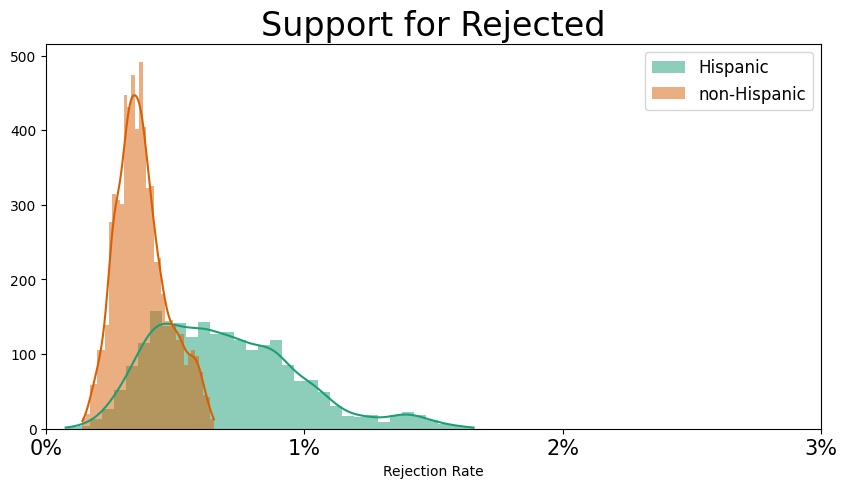

In [ ]:
ax = ei_2by2.plot_kde()
ax.set_xlim(0, 0.03)
ax.set_xticks([0, 0.01, 0.02, 0.03])
ax.set_xticklabels(["0%", "1%", "2%", "3%"])
ax.set_xlabel("Rejection Rate"